## In this notebook, we want to forcast the ratings of the first 3000 users

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster
import pandas as pd

### Clustering the history data

In [2]:
history = pd.read_csv('user_history.csv')
history.shape

(4500, 101)

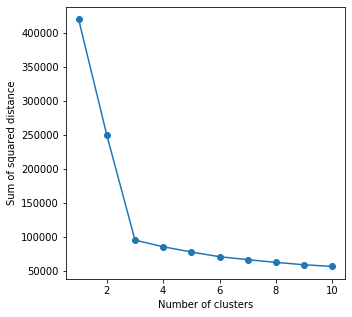

In [3]:
# We want to first clustering the history data
# By using elbow method
sse = []
list_k = list(range(1, 11))

for k in list_k:
    km = cluster.KMeans(n_clusters=k)
    km.fit(history.drop(['USER ID'], axis=1)) # we need to drop the first column(user id)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(5, 5))
plt.plot(list_k, sse, '-o')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distance')
plt.show()

In [4]:
# According to elbow method, the best k should be 3
kmeans = cluster.KMeans(3) 
kmeans.fit(history.drop(['USER ID'], axis=1))
kmeans_y = kmeans.predict(history.drop(['USER ID'], axis=1))

In [5]:
# Seperate first 3000 users by their labels
# Create three arrays for each cluster/group of users
First_Group = []
Second_Group = []
Third_Group = []

for i in range(3000): 
    if kmeans.labels_[i] == 0:
        First_Group.append(history['USER ID'].iloc[i])
    if kmeans.labels_[i] == 1:
        Second_Group.append(history['USER ID'].iloc[i])
    if kmeans.labels_[i] == 2:
        Third_Group.append(history['USER ID'].iloc[i])
        
First_Group = np.asarray(First_Group)
Second_Group = np.asarray(Second_Group)
Third_Group = np.asarray(Third_Group)

In [6]:
len(First_Group),len(Second_Group),len(Third_Group)

(1009, 983, 1008)

### Using Gradient Descent to predict the rating for the first 3000 users

In [7]:
# we can see that our reformat rating matrix is pretty sparse
reformat = pd.read_csv('user_data.csv')
reformat

,USER_ID,alaska basil,alcohol future,alice ticket,alien potato,asia jacket,aztec iris,balance hostel,betty today,boston house,...,trivial neon,tuna relax,tunnel nerve,turtle pierre,update vibrate,vampire teacher,ventura next,vodka bahama,volume pasta,zero nikita
0,100953,2.0,NaN,4.0,6.0,3.0,4.0,3.0,NaN,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,3.0,5.0
1,100955,6.0,4.0,NaN,5.0,NaN,NaN,NaN,6.0,NaN,...,7.0,7.0,NaN,5.0,NaN,NaN,6.0,NaN,NaN,4.0
2,100965,4.0,NaN,1.0,5.0,NaN,NaN,6.0,NaN,NaN,...,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,4.0
3,100968,10.0,NaN,1.0,3.0,NaN,5.0,7.0,6.0,NaN,...,8.0,9.0,NaN,NaN,NaN,10.0,10.0,NaN,10.0,2.0
4,100976,NaN,NaN,NaN,7.0,NaN,6.0,NaN,NaN,5.0,...,NaN,NaN,0.0,0.0,NaN,0.0,NaN,NaN,9.0,3.0
5,100986,NaN,8.0,0.0,NaN,0.0,NaN,5.0,8.0,NaN,...,NaN,9.0,5.0,7.0,NaN,2.0,NaN,NaN,8.0,NaN
6,100993,NaN,NaN,NaN,NaN,7.0,5.0,NaN,NaN,3.0,...,NaN,4.0,4.0,NaN,NaN,NaN,6.0,5.0,NaN,NaN
7,101001,NaN,NaN,NaN,2.0,NaN,8.0,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,8.0,9.0,NaN,2.0,9.0,8.0
8,101010,2.0,6.0,NaN,5.0,9.0,NaN,4.0,3.0,NaN,...,NaN,1.0,NaN,NaN,NaN,3.0,NaN,NaN,1.0,NaN
9,101013,1.0,7.0,8.0,7.0,NaN,NaN,NaN,4.0,7.0,...,NaN,2.0,NaN,6.0,NaN,NaN,NaN,2.0,1.0,NaN


In [8]:
#Generate Three Dataframes corresponding to train arrays for all three clusters
Clstr1_train = reformat[reformat['USER_ID'].isin(First_Group)]
Clstr2_train = reformat[reformat['USER_ID'].isin(Second_Group)]
Clstr3_train = reformat[reformat['USER_ID'].isin(Third_Group)]


In [9]:
##Since the target products in each dataframes are the same: exacly as those 100 products,
##So we store those products into a list
target_products = list(reformat.columns) 
target_products.remove(target_products[0]) #remove the item 'USER_ID'
target_products = np.asarray(target_products)

#type(target_products)
#print(target_products)
#len(target_products)
#After rechecking, we know that array is what we need.

In [10]:
def load_rating_clusters(dataframe):
    users = []
    products = []
    mapusers = []
    mapproducts = []
    ratings = []
    temp1 = dataframe.iloc[:,1:101]

    temp2 = np.array(temp1)
    rownumber = len(temp2)
    colnumber = temp2.shape[1]
    #Get ndArray of all column names 
    columnNames = list(dataframe.columns) 
    columnNames.remove(columnNames[0]) #remove the item 'USER_ID'
    columnNames = np.asarray(columnNames)
    #Get ndArray of all column names 
    rowNames = dataframe.iloc[:, 0]
    rowNames = np.array(rowNames)
    print(rownumber)
    print(colnumber)


    for i in range(rownumber): 
        for j in range(colnumber):
            if np.isnan(temp2[i,j]):
                continue
            users.append(rowNames[i])
            mapusers.append(i)
            products.append(columnNames[j])
            mapproducts.append(j)
            ratings.append(temp2[i,j])
    #reformat3_ratings = np.array(reformat3_ratings)
    users = np.array(users)

    products = np.array(products)
    mapusers = np.array(mapusers)
    mapproducts = np.array(mapproducts)
    ratings = np.array(ratings)
    return users,products,ratings,mapusers,mapproducts

users1_train,products1_train,ratings1_train,mapusers1_train,mapproducts1_train = load_rating_clusters(Clstr1_train)
users2_train,products2_train,ratings2_train,mapusers2_train,mapproducts2_train = load_rating_clusters(Clstr2_train)
users3_train,products3_train,ratings3_train,mapusers3_train,mapproducts3_train = load_rating_clusters(Clstr3_train)

1009
100
983
100
1008
100


In [11]:
learning_rate = 0.005

def initialize(n_users, n_products):
    """Initalize a random model, and normalize it so that it has sensible mean and variance"""
    # (The normalization helps make sure we start out at a reasonable parameter scale, which speeds up training)
    user_features = np.random.normal(size=(n_users,10)) # still setting the number of features as 10
    product_features = np.random.normal(size=(n_products,10)) # still setting the number of features as 10
    raw_predictions = predict((user_features, product_features))
    
    s = np.sqrt(2*raw_predictions.std()) # We want to start out with roughly unit variance
    b = np.sqrt(5 - raw_predictions.mean()/s) #We want to start out with average rating 5
    user_features /= s
    user_features += b
    product_features /= s
    product_features += b
    
    return (user_features, product_features)

def predict(model):
    """The model's predictions for all user/product pairs"""
    user_features, product_features = model
    return user_features @ product_features.T

def single_example_step(model, user, product, rating, train_users, train_products):
    """Update the model using the gradient at a single training example"""
    user_features, product_features = model
    # only consider rating which is not 'nan'

    residual = np.dot(user_features[user], product_features[product]) - rating
    #for i in range(len(residual)):
    #    residual[i]-=rating[i]
    grad_users = 2 * residual * product_features[product] # the gradient for the user_features matrix
    grad_products = 2 * residual * user_features[user] # the gradient for the product_features matrix
    #print(grad_users.shape,grad_products.shape)
    user_features[user] -= learning_rate*grad_users
    product_features[product] -= learning_rate*grad_products

def train_sgd(model, epochs, train_users, train_products, train_ratings, test_users, test_products, test_ratings,mapusers_train,mapproducts_train,mapusers_test,mapproducts_test):
    """Train the model for a number of epochs via SGD (batch size=1)"""
    user_features, movie_features = model
    # It's good practice to shuffle your data before doing batch gradient descent,
    # so that each mini-batch peforms like a random sample from the dataset
#     print()  
    training_process = []
    uniquetrain_users = list(np.unique(train_users))
    uniquetrain_products = list(np.unique(train_products))
    uniquetest_users = np.unique(test_users)
    uniquetest_products = np.unique(test_products)
    shuffle = np.random.permutation(len(train_users))
    shuffled_users = train_users[shuffle]
    shuffled_products = train_products[shuffle]
    shuffled_ratings = train_ratings[shuffle]
    
    for epoch in range(epochs):
        for user, product, rating in zip(shuffled_users, shuffled_products, shuffled_ratings):
            # update the model using the gradient at a single example
            if np.isnan(rating):
                continue
            user = uniquetrain_users.index(user)
            product = uniquetrain_products.index(product)
            single_example_step(model, user, product, rating, uniquetrain_users, uniquetrain_products)
        # after each Epoch, we'll evaluate our model
        
        predicted = predict(model)

        train_loss = np.mean((train_ratings - predicted[mapusers_train,mapproducts_train])**2)
        test_loss = np.mean((test_ratings - predicted[mapusers_test,mapproducts_test])**2)
        training_process.append((epoch,train_loss))
        print("Loss after epoch #{} is: train/{} --- test/{}".format(epoch+1, train_loss, test_loss))
    return training_process

sgd_model_1 = initialize(len(list(np.unique(users1_train))), 100)
sgd_model_2 = initialize(len(list(np.unique(users2_train))), 100)
sgd_model_3 = initialize(len(list(np.unique(users3_train))), 100)
training_process_1 = train_sgd(sgd_model_1, 20, users1_train, products1_train, ratings1_train, users1_train, products1_train, ratings1_train,mapusers1_train,mapproducts1_train,mapusers1_train,mapproducts1_train)
training_process_2 = train_sgd(sgd_model_2, 20, users2_train, products2_train, ratings2_train, users2_train, products2_train, ratings2_train,mapusers2_train,mapproducts2_train,mapusers2_train,mapproducts2_train)
training_process_3 = train_sgd(sgd_model_3, 20, users3_train, products3_train, ratings3_train, users3_train, products3_train, ratings3_train,mapusers3_train,mapproducts3_train,mapusers3_train,mapproducts3_train)

Loss after epoch #1 is: train/6.534419808247296 --- test/6.534419808247296
Loss after epoch #2 is: train/0.9311041990224813 --- test/0.9311041990224813
Loss after epoch #3 is: train/0.6822764461118751 --- test/0.6822764461118751
Loss after epoch #4 is: train/0.6034553970192305 --- test/0.6034553970192305
Loss after epoch #5 is: train/0.5585892703732549 --- test/0.5585892703732549
Loss after epoch #6 is: train/0.5290282347813026 --- test/0.5290282347813026
Loss after epoch #7 is: train/0.5055564735737409 --- test/0.5055564735737409
Loss after epoch #8 is: train/0.4832891537996869 --- test/0.4832891537996869
Loss after epoch #9 is: train/0.46013921917530903 --- test/0.46013921917530903
Loss after epoch #10 is: train/0.4358932348703301 --- test/0.4358932348703301
Loss after epoch #11 is: train/0.4113745296458348 --- test/0.4113745296458348
Loss after epoch #12 is: train/0.38764770379556984 --- test/0.38764770379556984
Loss after epoch #13 is: train/0.3654842631416387 --- test/0.3654842631

In [12]:
predicted_1 = predict(sgd_model_1)
predicted_2 = predict(sgd_model_2)
predicted_3 = predict(sgd_model_3)

newpredicted_1 = pd.DataFrame(predicted_1,index = Clstr1_train.index,columns = Clstr1_train.columns[1:])
newpredicted_1.insert(0,'USER_ID', Clstr1_train['USER_ID'])
newpredicted_2 = pd.DataFrame(predicted_2,index = Clstr2_train.index,columns = Clstr2_train.columns[1:])
newpredicted_2.insert(0,'USER_ID', Clstr2_train['USER_ID'])
newpredicted_3 = pd.DataFrame(predicted_3,index = Clstr3_train.index,columns = Clstr3_train.columns[1:])
newpredicted_3.insert(0,'USER_ID', Clstr3_train['USER_ID'])

In [13]:
Clstr1_train[Clstr1_train.isnull()] = newpredicted_1[Clstr1_train.isnull()]
Clstr2_train[Clstr2_train.isnull()] = newpredicted_2[Clstr2_train.isnull()]
Clstr3_train[Clstr3_train.isnull()] = newpredicted_3[Clstr3_train.isnull()]

Clstr_train = pd.concat([Clstr1_train,Clstr2_train,Clstr3_train])
Clstr_train = Clstr_train.sort_values(by="USER_ID",ascending=True).round(0).to_csv("tzzs_data.csv")

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
//anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3414: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._where(-key, value, inplace=True)
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/sta